## 03 - Models

The following notebook will build the models to predict book sales (units sold).
Two approaches are used - linear regression variants and random forest. Linear
regression gives a some concrete number on how each feature effecting the daily
units sold while random forest will provide a better fitted model. On the end,
we want to find the best indicators of a popular books.

Pipelines:
1. features cleaning and engineering
2. GridsearchCV ridge and lasso regression => refit better algorithm and interpretation
3. GridsearchCV boosting and random forest => refit better algorithm and interpretation

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from book_analysis.utils.visuals import *
# %matplotlib inline
# plt.style.use('seaborn-white')

In [2]:
# load data
data_path = 'D:\\PycharmProjects\\springboard\\data'
df = pd.read_csv(f'{data_path}\\book_sales.csv', index_col=[0])

# original datsets
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27027 entries, 0 to 27026
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   genre                     27027 non-null  object 
 1   sold_by                   27027 non-null  object 
 2   daily_average_units_sold  27027 non-null  int64  
 3   publisher_name            27027 non-null  object 
 4   publisher_type            27027 non-null  object 
 5   average_rating            27027 non-null  float64
 6   sale_price                27027 non-null  float64
 7   total_reviews             27027 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 1.9+ MB


## 1 - Features cleaning and engineering

Steps are as followed:

1. Encode genre, sold_by, publisher_type using dummies
One level from each categorical is removed to prevent collinearity
2. Log transform sale price and units sold to normalize the long tail
3. publisher name will be transformed using hashing trick. The output feature
space chosen is very small at 309 - the same number of unique publisher name.
There will be some collision. However, the small number of features reduces training time significantly.


In [3]:
# transform genre, sold_by and publisher_type into dummies
# dropping the first level from each variable
for col in ['genre', 'sold_by', 'publisher_type']:
    df = pd.get_dummies(df,
                        columns=[col],
                        prefix=col,
                        drop_first=True)

In [4]:
# set feature hashing parameters
fh = FeatureHasher(n_features=309, input_type='string')

# get hashed features array
hashed_features = fh.fit_transform(df['publisher_name']).toarray()

# added hashed_features into df
df = pd.concat([df, pd.DataFrame(hashed_features)], axis=1)

# drop publisher_name columns
df = df.drop('publisher_name', axis=1)
df.head()

,daily_average_units_sold,average_rating,sale_price,total_reviews,genre_comics,genre_fiction,genre_foreign language,genre_genre fiction,genre_nonfiction,sold_by_Cengage Learning,...,299,300,301,302,303,304,305,306,307,308
0,7000,4.57,4.88,9604,0,0,0,1,0,0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6250,4.47,1.99,450,0,0,0,1,0,0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5500,4.16,8.69,30,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5500,3.84,7.50,3747,0,1,0,0,0,0,...,0.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
4,4750,4.75,7.99,9174,0,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we proceed to split the data into train and test sets. Values are also
scaled for ridge/lasso regression. Daily units sold is log transformed because
of the very long tail.

In [5]:
# get X and y
X = df.drop(['daily_average_units_sold'], axis=1)
y = df.daily_average_units_sold

# log transform the sale price
X['sale_price'] = np.log(X['sale_price'])

# log transform y
y = np.log(y)

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# scale X for Ridge/Lasso regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# set up k fold
kf = KFold(n_splits=5, shuffle=True, random_state=41)

# 2 - Ridge and Lasso regression

Lets compare the two linear methods: Ridge and Lasso. Setting up model selection
using GridsearchCV for best alpha. Alpha represents the regularization parameter
over normal OLS model.

Note: the refit=True in GridsearchCV refit the model on the whole data each time. Thus,
there is no need to refit the whole model again. Alpha range is limited to
50 to speed up the training.

In [6]:
# Set up alphas range from small to very large
alphas = 10**np.linspace(10,-2,50)*0.5

# dictionary mapping model and hyper-parameter
models_and_parameters = {'ridge': (Ridge(), {'alpha': alphas}),
                         'lasso': (Lasso(max_iter=10000), {'alpha': alphas})}

# collect average score of 5 outer folds
rmse_dict = dict()

# find the best model with lowest mse
for name, (model, params) in tqdm(models_and_parameters.items()):
    # searches for the best hyper-parameter using inner folds
    grid = GridSearchCV(estimator=model,
                        param_grid=params,
                        cv=3,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1)
    grid_result = grid.fit(X_train_scaled, y_train)

    # Test set error
    y_pred = grid.predict(X_test_scaled)
    test_rmse = np.round(mean_squared_error(y_test, y_pred), 2)

    # adding the test rmse into the dictionary for comparison
    rmse_dict[name] = test_rmse

    # Print error summary 
    error_summary = f'Model: {name}' \
                    f'\nTrain RMSE: {np.round(-1 * grid_result.best_score_, 2)}' \
                    f'\nTest RMSE: {test_rmse}' \
                    f'\nBest params: {grid_result.best_params_}'
    print(error_summary)
    print()

100%|██████████| 2/2 [00:14<00:00,  7.33s/it]


Model: ridge
Train RMSE: 1.05
Test RMSE: 1.12
Best params: {'alpha': 23.57433181728695}

Model: lasso
Train RMSE: 1.05
Test RMSE: 1.12
Best params: {'alpha': 0.005}



## 2.1 - Lasso Refit

Both ridge and lasso gives the same test RMSE. Thus, choosing either one is acceptable.
Lets proceed using Lasso by refitting the whole dataset and observe the coefficients.
All the hashed features space is ignored from interpretation.

Insights:
1. Price has a negative relationship with sales. On average, a 100% increase
in ebook price decrease sales by 15.57%
2. Increasing rating by 1 star only generate 6.76% more sales.
3. On the other hand, 1 more review can be as impactful as increasing sales by
34.36%.
4. Genre:
    * genre fiction books generate 52.71% more sales on average than children books
    * fiction books generate 19.52% more sales on average than children books
    * non fiction books generate 12.52% more sales on average than children books
    * all others are either too small or has negative impact on sales
5. Books sell by Random House generates the least sales
6. With the baseline of publisher type is amazon, we have:
    * books from big five publishers generate 3.11% less sales than amazon published books
    * books from small/medium publishers generate 5.85% less sales than amazon published books

In [7]:
# Fit ridge regression with RidgeCV alphas
lasso = Lasso(alpha=0.005).fit(X_scaled,y)

# None of the coefficients are reduced to 0 but very to closed to it.
pd.Series(lasso.coef_, index=X.columns)[:25]

average_rating                                  0.067603
sale_price                                     -0.155722
total_reviews                                   0.343645
genre_comics                                    0.009161
genre_fiction                                   0.195206
genre_foreign language                         -0.027198
genre_genre fiction                             0.527134
genre_nonfiction                                0.125233
sold_by_Cengage Learning                       -0.003759
sold_by_DC Comics                               0.018585
sold_by_Hachette Book Group                     0.000000
sold_by_HarperCollins                           0.004168
sold_by_Idea & Design Works                     0.003617
sold_by_Macmillan                              -0.035322
sold_by_Penguin Group (USA) LLC                -0.000000
sold_by_RCS MediaGroup S.p.A.                  -0.000000
sold_by_Random House                           -0.076471
sold_by_Simon and Schuster Digi

### 3 - Boosting and random forest

Boosting and random forest are the popular alternatives to linear methods above.
The advantage of tree based methods is better performance at the cost
of training time and much more optimization needed. There are over 10 hyper parameters
to be tuned for each algorithm. However, we only search for max depth as training
time increases significantly to tune another hyper parameter and the performance
is not improving much.

The fitting process is the same as before with GridsearchCV

In [8]:
# Set up alphas range from small to very large
max_depth = [2,5,10,100,200]
learning_rate = np.linspace(0.1,5,10)

# dictionary mapping model and hyper-parameter
models_and_parameters = {
    'random_forest': (RandomForestRegressor(), {'max_depth': max_depth}),
    'boosting': (GradientBoostingRegressor(), {'learning_rate': learning_rate, 'max_depth': max_depth})}

# find the best model with lowest mse
for name, (model, params) in tqdm(models_and_parameters.items()):
    # searches for the best hyper-parameter using inner folds
    grid = GridSearchCV(estimator=model,
                        param_grid=params,
                        cv=3,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1)
    # fit
    grid_result = grid.fit(X_train_scaled, y_train)

    # Test set error
    y_pred = grid.predict(X_test_scaled)
    test_rmse = np.round(mean_squared_error(y_test, y_pred), 2)

    # adding the test rmse into the dictionary for comparison
    rmse_dict[name] = test_rmse

    # Print error summary
    error_summary = f'Model: {name}' \
                    f'\nTrain RMSE: {np.round(-1 * grid_result.best_score_, 2)}' \
                    f'\nTest RMSE: {test_rmse}' \
                    f'\nBest params: {grid_result.best_params_}'
    print(error_summary)
    print()

100%|██████████| 2/2 [07:30<00:00, 225.01s/it]


Model: random_forest
Train RMSE: 0.94
Test RMSE: 0.91
Best params: {'max_depth': 10}

Model: boosting
Train RMSE: 0.94
Test RMSE: 0.89
Best params: {'learning_rate': 0.1, 'max_depth': 5}



### 3.1 - Refit random forest

Now we use the best hyper parameter on training data to get the test MSE

In [9]:
# refit with best hyper params on whole data
rf = RandomForestRegressor(max_depth=10)
rf.fit(X_scaled, y)

# feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)[:23]
feature_importance

average_rating                                  5.696393e-02
sale_price                                      1.013560e-01
total_reviews                                   3.973676e-01
genre_comics                                    2.741295e-04
genre_fiction                                   3.172854e-02
genre_foreign language                          7.324023e-04
genre_genre fiction                             2.693267e-01
genre_nonfiction                                6.481650e-03
sold_by_Cengage Learning                        2.666228e-05
sold_by_DC Comics                               6.470260e-04
sold_by_Hachette Book Group                     6.402864e-04
sold_by_HarperCollins                           1.264437e-03
sold_by_Idea & Design Works                     1.166535e-04
sold_by_Macmillan                               4.905287e-04
sold_by_Penguin Group (USA) LLC                 1.098278e-03
sold_by_RCS MediaGroup S.p.A.                   3.812607e-07
sold_by_Random House    

Feature importance shows the same intuition as our ridge regression above.

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


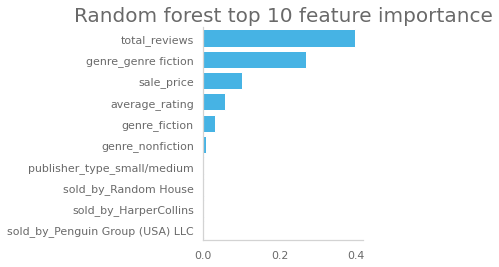

In [10]:
# top 10 feature importance
top_10 = feature_importance.sort_values(ascending=False)[:10].reset_index()

# plot top 10 feature importance
sns.barplot(x=0,
            y='index',
            data=top_10,
            color='#2CBDFE')

# plot parameters
plt.title('Random forest top 10 feature importance')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('D:\\PycharmProjects\\springboard\\ebook_analysis\\images\\feature_importance.png')